# Raster, Shapefile and CSV files 

In [24]:
import pandas as pd 
import rasterio
from rasterio import mask 
from rasterio.plot import show
import numpy as np 
#from rasterstats import zonal_stats
#import rasterstats
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import contextily as ctx
import os
import sys

In [13]:
os.getcwd()

'C:\\Users\\zamanim\\Desktop\\Python Workshop'

In [6]:
sys.version

'3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC v.1929 64 bit (AMD64)]'

# Load Raster

Download the global GHS-Pop GeoTiff rasters (.tif) for 2015. The data can be found [here](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop).  



In [7]:
### GHS-Pop 2015 Global Data using Rasterio.open
Raster=("path", "r")

# Load Shapefile

Go to the GDAM website and download the shape files (.shp) for Senegal (all admin levels). The data can be found [here](https://gadm.org/download_country.html]).

In [9]:
### Senegal admin 0 .shp boundary using geopandas 
gpd.read_file(".shp")

# Masking raster using a shapefile

In [21]:
### Clip both GHS-Pop 2015 to the Senegal admin 0 .shp boundary
with fiona.open("/gadm41_SEN_shp/gadm41_SEN_0.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    
with rasterio.open("/GHS_POP_2015/GHS2015.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("/GHS_POP_2015/clip_GHS2015.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# Visualizing raster layer

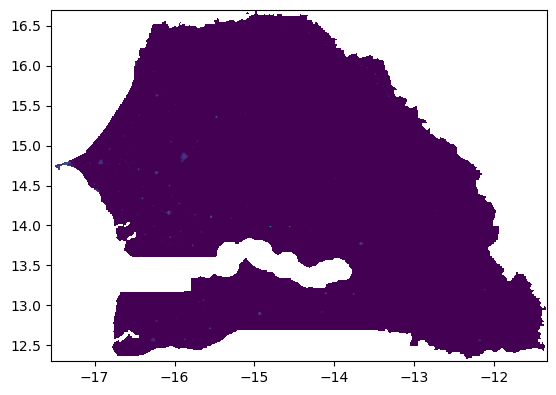

<AxesSubplot: >

In [19]:
clipped=r"/GHS_POP_2015/clip_GHS_2015.tif"
raster=rasterio.open(clipped)
show(raster)

# Load .csv files

In [4]:
### Load the .csv files with the cluster lat/long coordinates for the Senegal DHS 2016 survey.
df = pd.read_csv('/DHS-Senegal-2016-Clusters.csv')
df

,SurveyId,lat,long
0,SN2016DHS,14.690535,-17.450856
1,SN2016DHS,14.690535,-17.450856
2,SN2016DHS,14.690535,-17.450856
3,SN2016DHS,14.690535,-17.450856
4,SN2016DHS,14.690535,-17.450856
...,...,...,...
6720,SN2016DHS,12.622397,-15.331498
6721,SN2016DHS,12.622397,-15.331498
6722,SN2016DHS,12.622397,-15.331498
6723,SN2016DHS,12.622397,-15.331498


In [13]:
### Convert the data frame to a geodataframe 
### (Hint: to do this you'll need to convert the lat/long to points - GeoPandas can do this)
gdf=gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
print(gdf)

       SurveyId        lat       long                    geometry
0     SN2016DHS  14.690535 -17.450856  POINT (-17.45086 14.69054)
1     SN2016DHS  14.690535 -17.450856  POINT (-17.45086 14.69054)
2     SN2016DHS  14.690535 -17.450856  POINT (-17.45086 14.69054)
3     SN2016DHS  14.690535 -17.450856  POINT (-17.45086 14.69054)
4     SN2016DHS  14.690535 -17.450856  POINT (-17.45086 14.69054)
...         ...        ...        ...                         ...
6720  SN2016DHS  12.622397 -15.331498  POINT (-15.33150 12.62240)
6721  SN2016DHS  12.622397 -15.331498  POINT (-15.33150 12.62240)
6722  SN2016DHS  12.622397 -15.331498  POINT (-15.33150 12.62240)
6723  SN2016DHS  12.622397 -15.331498  POINT (-15.33150 12.62240)
6724  SN2016DHS  12.622397 -15.331498  POINT (-15.33150 12.62240)

[6725 rows x 4 columns]


<AxesSubplot: >

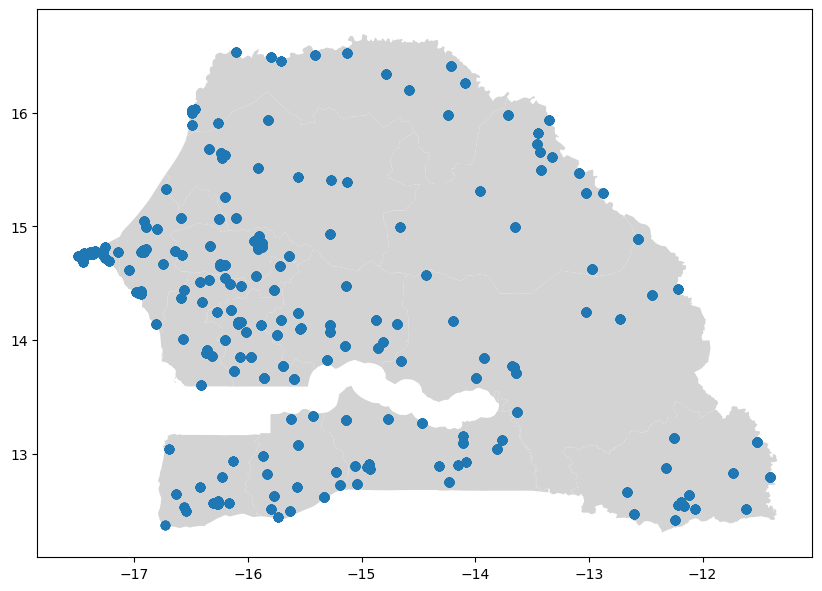

In [14]:
## create a figure 
fig, ax = plt.subplots(figsize = (10,10))
senegal_map = gpd.read_file(r'/gadm41_SEN_shp/gadm41_SEN_1.shp')
crs = {'init':'EPSG:4326'}
senegal_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax)

# Create buffer

In [6]:
### 5000 meters Buffer 
gdf.geometry = gdf.geometry.buffer(5000)
gdf.head()

,SurveyId,lat,long,geometry
0,SN2016DHS,14.690535,-17.450856,"POLYGON ((4982.549 14.691, 4958.473 -475.395, ..."
1,SN2016DHS,14.690535,-17.450856,"POLYGON ((4982.549 14.691, 4958.473 -475.395, ..."
2,SN2016DHS,14.690535,-17.450856,"POLYGON ((4982.549 14.691, 4958.473 -475.395, ..."
3,SN2016DHS,14.690535,-17.450856,"POLYGON ((4982.549 14.691, 4958.473 -475.395, ..."
4,SN2016DHS,14.690535,-17.450856,"POLYGON ((4982.549 14.691, 4958.473 -475.395, ..."


# Add basemap

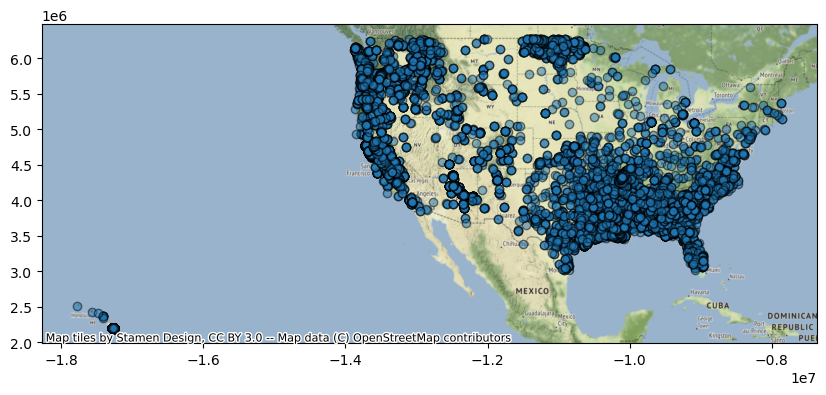

In [3]:
# Create a map with MODIS active fires 

##Load the shapefile in geopandas
df=gpd.read_file("FIRE/fire_archive_M-C61_301218.shp")

# Show the active fires in a map
df.crs
df_wm = df.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

# Raster calculation


In [25]:
fp = r"/annual_composite_2017.tif"

raster = rasterio.open(fp)

Here, we will be calculating NDVI (Normalized difference vegetation index) based on the Landsat dataset. For calculating the NDVI (Normalized difference vegetation index) you need two bands: band-4 which is the Red channel and band-5 which is the Near Infrared (NIR)

Let’s read those bands from our raster source

In [26]:
red = raster.read(4)

nir = raster.read(5)

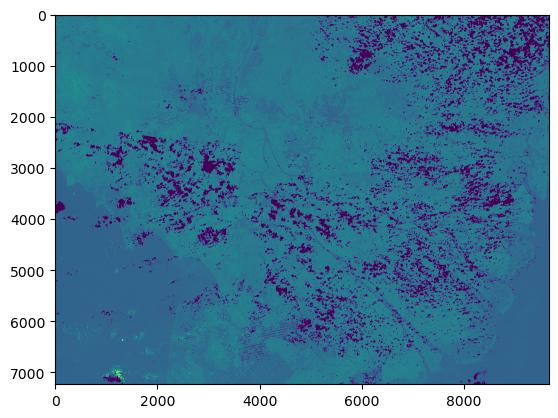

<AxesSubplot: >

In [29]:
red
type(red)
show(red)

In [31]:
nir
type(nir)

numpy.ndarray

As we can see the values are stored as numpy.ndarray.

Let’s change the data type from uint8 to float so that we can have floating point numbers stored in our arrays.

In [33]:
red = red.astype(float)

nir = nir.astype(float)

nir

array([[ 2767.,  2704.,  2411., ..., -9999.,  2085.,  2208.],
       [ 2389.,  2312.,  2059., ..., -9999.,  2085.,  2155.],
       [ 2671.,  2652.,  2663., ..., -9999.,  2235.,  2199.],
       ...,
       [  213.,   213.,   412., ...,    82.,   119.,   160.],
       [  222.,   314.,   213., ...,   152.,   132.,   131.],
       [  226.,   195.,   221., ...,   171.,   191.,   192.]])

Now we can see that the numbers changed to decimal numbers.

Next we need to tweak the behaviour of numpy a little bit. By default numpy will complain about dividing with zero values. We need to change that behaviour because we have a lot of 0 values in our data.

Allow 0 division in numpy

In [34]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Now we need to initialize the ndvi with zeros before we do the calculations (this is numpy specific trick)

In [35]:
ndvi = np.empty(raster.shape, dtype=rasterio.float32)

Now we are ready to calculate the NDVI. First, we can create a filter where we calculate the values on such pixels that have a value larger than 0.

In [36]:
check = np.logical_or ( red > 0, nir > 0 )

Now we can apply that filter and calculate the ndvi index.

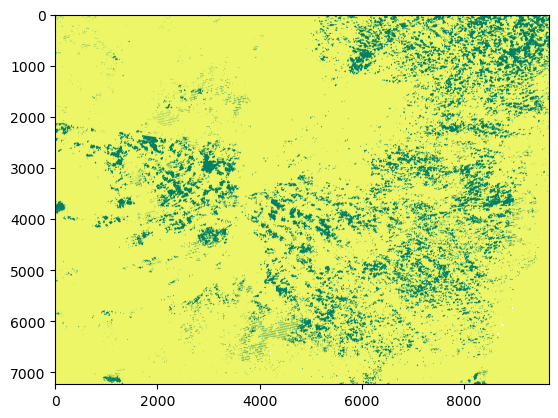

<AxesSubplot: >

In [39]:
ndvi = np.where ( check,  (nir - red ) / ( nir + red ), -999 )

show(ndvi, cmap='summer')